## Wrist Orientation Analysis

### Data Preprocessing

In [96]:
import pandas as pd
import numpy as np

# Load data and set index
quat_data = pd.read_csv('../data/samples/free_quat.csv')
quat_data['time_s'] = pd.to_datetime(quat_data['time_s'], unit='s')
quat_data = quat_data.set_index('time_s')

# Drop rows with quaternion components equal to zero
quat_cols = ['qw', 'qx', 'qy', 'qz']
quat_data[quat_cols] = quat_data[quat_cols].replace(0, np.nan)
quat_data = quat_data.dropna()

# Resample to 40 hz
quat_data = quat_data.resample('25L').mean().interpolate()

quat_data.head()

C:\Users\warren\AppData\Local\Temp\ipykernel_22928\1660224942.py:15: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  quat_data = quat_data.resample('25L').mean().interpolate()


,ax,ay,az,gx,gy,gz,qx,qy,qz,qw
time_s,,,,,,,,,,
1970-01-01 00:00:03.200,-6.20700,-1.57030,6.70700,0.1152,-0.72850,-0.17190,-0.20610,0.21300,0.51890,0.80190
1970-01-01 00:00:03.225,-6.85160,-1.91410,6.51170,0.2441,-1.36520,-0.33590,-0.20610,0.21300,0.51890,0.80190
1970-01-01 00:00:03.250,-5.58985,-1.87695,6.58985,0.3740,-1.16795,-0.41015,-0.19765,0.20270,0.51835,0.80685
1970-01-01 00:00:03.275,-4.32810,-1.83980,6.66800,0.5039,-0.97070,-0.48440,-0.18920,0.19240,0.51780,0.81180
1970-01-01 00:00:03.300,-6.10940,-1.76175,6.91015,0.7793,-1.88475,-0.66795,-0.17700,0.18245,0.51380,0.81915


### Rotate Acceleration Vectors to Earth Frame

Text(0.5, 1.0, 'Rotated Acceleration Data (Earth Frame)')

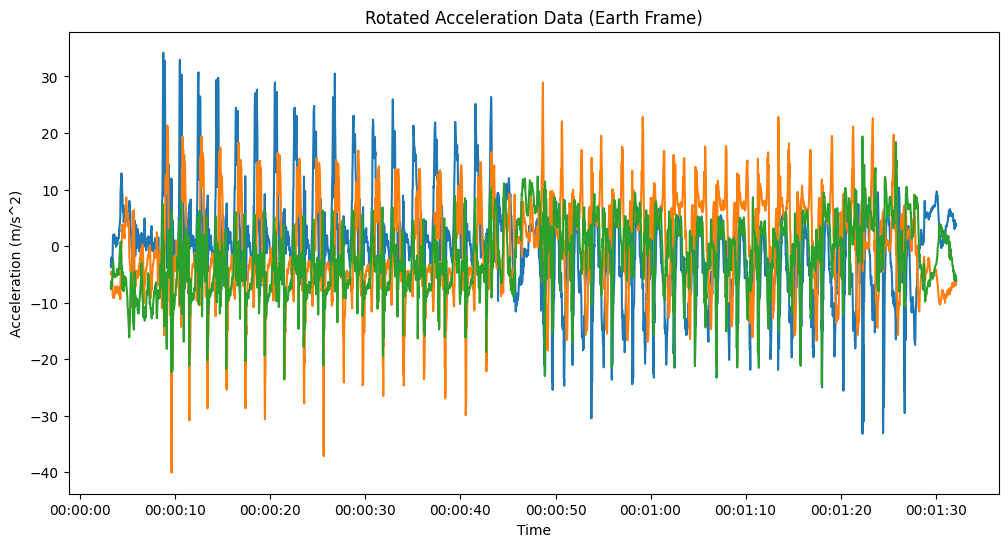

In [98]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

# Extract acceleration and quaternion data as numpy arrays
accel_data_values = quat_data[['ax', 'ay', 'az']].values
quat_data_values = quat_data[['qw', 'qx', 'qy', 'qz']].values

# Create rotation objects and apply to acceleration data
rotations = R.from_quat(quat_data_values)
accel_data_values_rotated = rotations.apply(accel_data_values)

# Create DataFrame for rotated acceleration data
accel_data_rotated = pd.DataFrame(accel_data_values_rotated, index = quat_data.index, columns=['acc_x', 'acc_y', 'acc_z'])

# Plot the rotated acceleration data
plt.figure(figsize=(12, 6))
plt.plot(accel_data_rotated.index, accel_data_rotated['acc_x'], label='Forward Acceleration')
plt.plot(accel_data_rotated.index, accel_data_rotated['acc_y'], label='Lateral Acceleration')
plt.plot(accel_data_rotated.index, accel_data_rotated['acc_z'], label='Vertical Acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Rotated Acceleration Data (Earth Frame)')

### Align World Frame to Pool Direction

In [99]:
vel_draft = pd.DataFrame(np.cumsum(accel_data_rotated.values, axis=0) * 0.025, index=accel_data_rotated.index)
disp_draft = pd.DataFrame(np.cumsum(vel_draft.values, axis=0) * 0.025, index=accel_data_rotated.index)

turn_time_s = 43.0
turn_time_td = pd.to_timedelta(turn_time_s, unit='s')
end_of_lap_disp = disp_draft[disp_draft.index < (disp_draft.index[0] + turn_time_td)].iloc[-1].values

fwd_vec = end_of_lap_disp / np.linalg.norm(end_of_lap_disp)

global_up_vec = np.array([0, 0, 1])
lat_vec = np.cross(fwd_vec, global_up_vec)
lat_vec /= np.linalg.norm(lat_vec)
vert_vec = np.cross(lat_vec, fwd_vec)

rotation_matrix = np.array([fwd_vec, lat_vec, vert_vec]).T
acc_original = accel_data_rotated[['acc_x', 'acc_y', 'acc_z']].values
acc_aligned = np.dot(acc_original, rotation_matrix)

accel_data_aligned = pd.DataFrame(acc_aligned, index=accel_data_rotated.index, columns=['acc_fwd', 'acc_lat', 'acc_vert'])

### Apply Noise Filtering

Text(0.5, 1.0, 'Filtered, Rotated Acceleration Data')

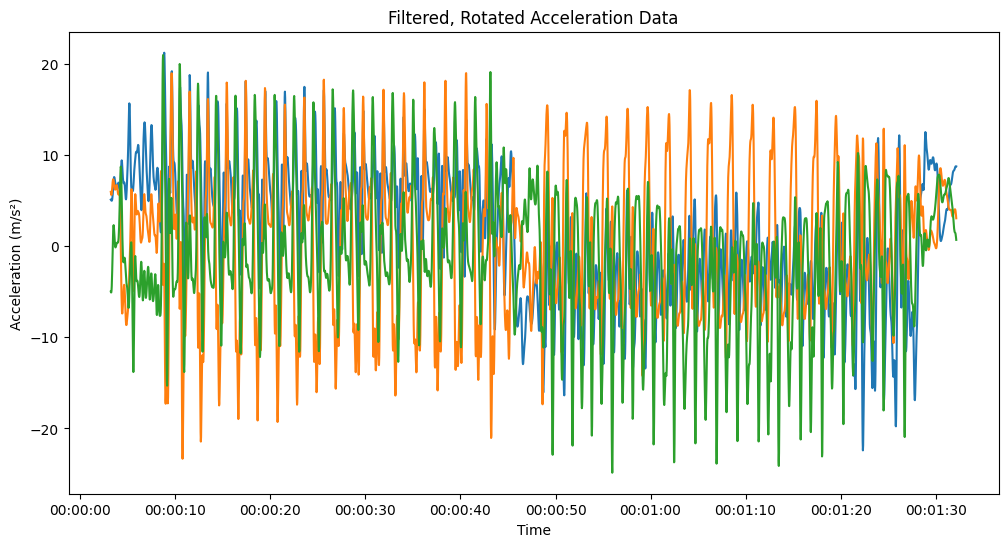

In [100]:
from scipy.signal import butter, filtfilt

accel_data_filtered = accel_data_aligned.copy()

fs = 40
nyquist = 0.5 * fs
cutoff_low = 4
order = 5
normal_cutoff = cutoff_low / nyquist

for col in accel_data_filtered.columns:
    b, a = butter(order, normal_cutoff, btype='low', analog=False, output='ba') # type: ignore
    accel_data_filtered[col] = filtfilt(b, a, accel_data_filtered[col])

# Plot the filtered acceleration data
plt.figure(figsize=(12, 6))
plt.plot(accel_data_filtered.index, accel_data_filtered['acc_fwd'], label='Forward Acceleration')
plt.plot(accel_data_filtered.index, accel_data_filtered['acc_lat'], label='Lateral Acceleration')
plt.plot(accel_data_filtered.index, accel_data_filtered['acc_vert'], label='Vertical Acceleration')
plt.xlabel('Time')
plt.ylabel('Acceleration (m/s²)')
plt.title('Filtered, Rotated Acceleration Data')

### Perform Integration to get Velocity

Text(0.5, 1.0, 'Velocity Data')

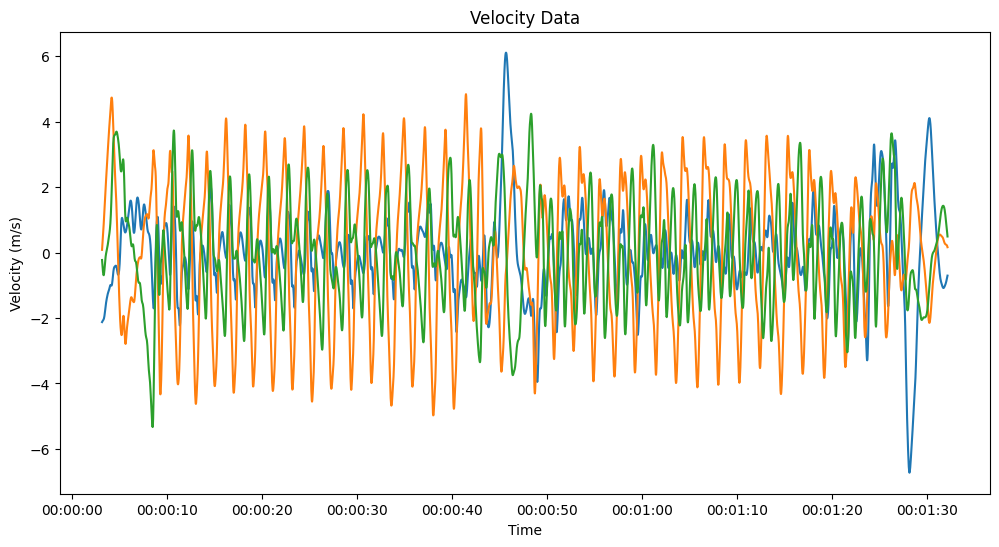

In [101]:
# Perform integration to get velocity
vel_data = pd.DataFrame(index = accel_data_filtered.index)
for col in accel_data_filtered.columns:
    velocity = np.cumsum(accel_data_filtered[col]) * (1/fs)
    vel_data[col.replace('acc', 'vel')] = velocity

# Apply a high-pass filter to remove drift
cutoff_high = 0.1
nyquist = 0.5 * fs
normal_cutoff = cutoff_high / nyquist

for col in vel_data.columns:
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba') # type: ignore
    vel_data[col] = filtfilt(b, a, vel_data[col])

# Plot the velocity data
plt.figure(figsize=(12, 6))
plt.plot(vel_data.index, vel_data['vel_fwd'], label='Forward Velocity')
plt.plot(vel_data.index, vel_data['vel_lat'], label='Lateral Velocity')
plt.plot(vel_data.index, vel_data['vel_vert'], label='Vertical Velocity')
plt.xlabel('Time')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity Data')

### Perform Second Integration to get Displacement

Text(0.5, 1.0, 'Displacement Data')

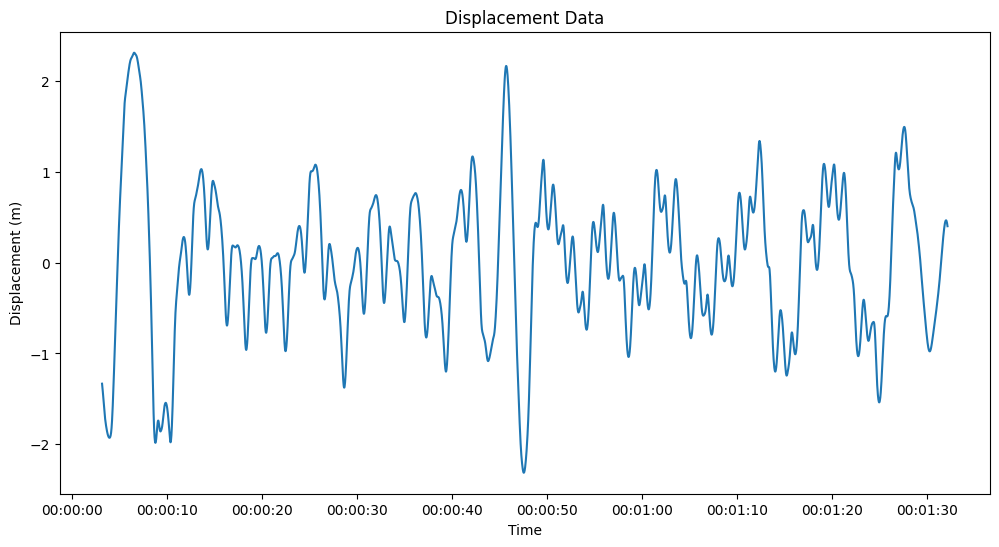

In [ ]:
# Perform second integration to get displacement
disp_data = pd.DataFrame(index = vel_data.index)
for col in vel_data.columns:
    displacement = np.cumsum(vel_data[col]) * (1/fs)
    disp_data[col.replace('vel', 'disp')] = displacement

# Apply another high-pass filter to remove drift
for col in disp_data.columns:
    b, a = butter(order, normal_cutoff, btype='high', analog=False, output='ba') # type: ignore
    disp_data[col] = filtfilt(b, a, disp_data[col])

# Plot the displacement data
plt.figure(figsize=(12, 6))
plt.plot(disp_data.index, disp_data['disp_fwd'], label='Forward Displacement')
plt.plot(disp_data.index, disp_data['disp_lat'], label='Lateral Displacement')
plt.plot(disp_data.index, disp_data['disp_vert'], label='Vertical Displacement')
plt.xlabel('Time')
plt.ylabel('Displacement (m)')
plt.title('Displacement Data')